In [1]:
!nvidia-smi

Tue Jan 12 15:32:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 43kB/s 


## Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load and Inspect the NIFTY50 Index Data

In [4]:
df = pd.read_csv('/content/NIFTY50.csv', parse_dates=['date'], index_col='date')

In [5]:
df.head()

,close
date,
1994-01-03,1083.74
1994-01-04,1091.81
1994-01-05,1082.80
1994-01-06,1098.91
1994-01-07,1146.31


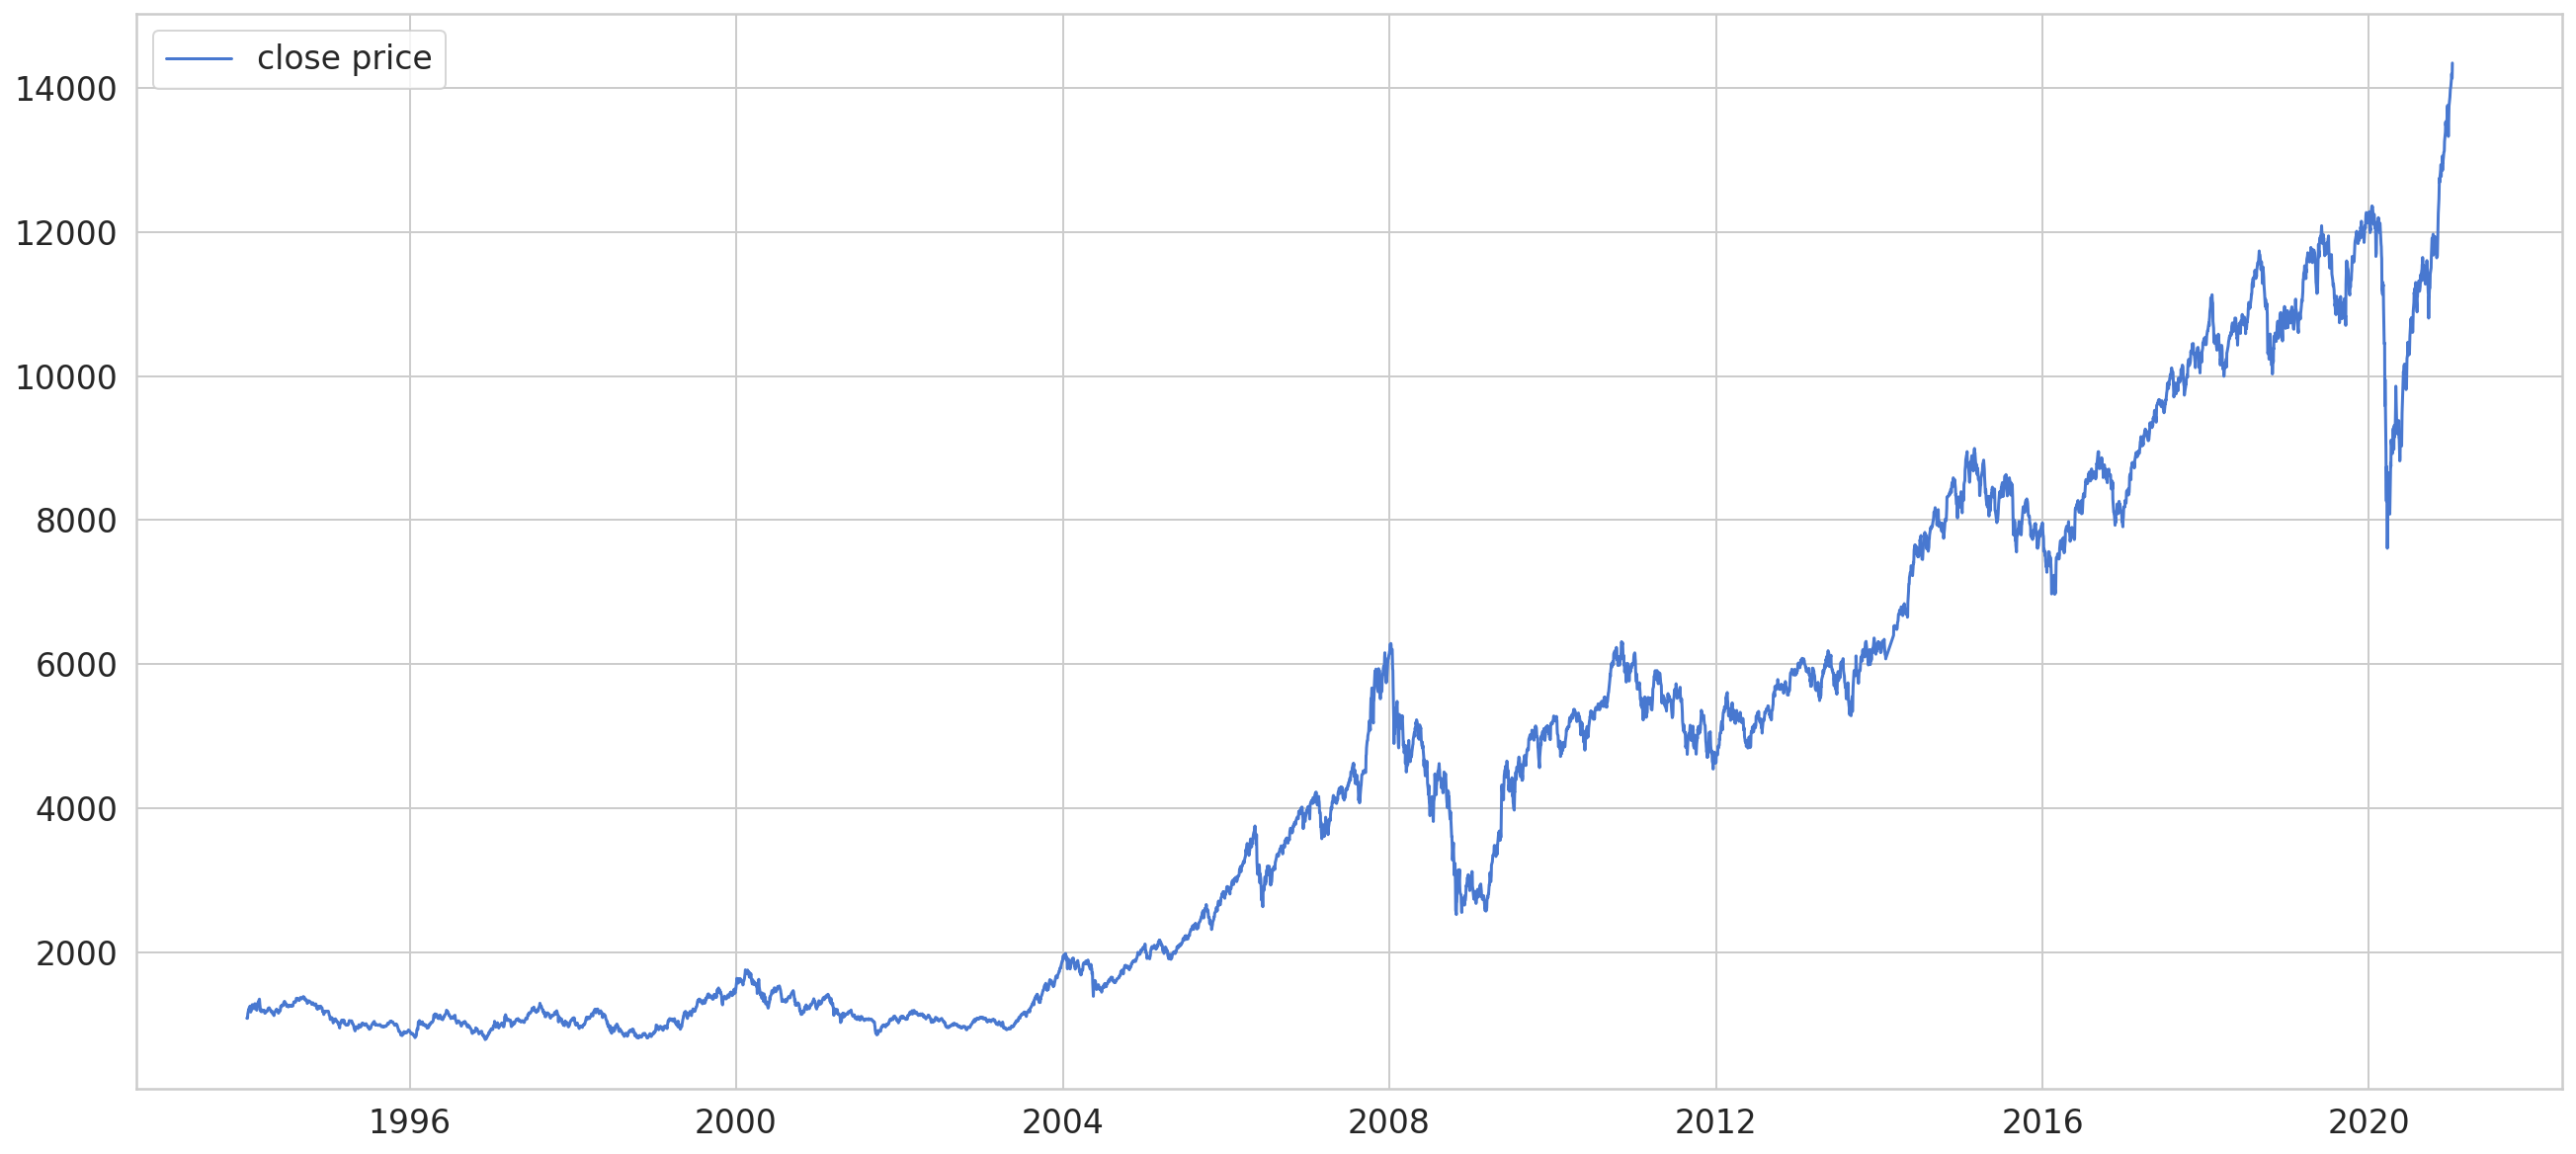

In [6]:
plt.plot(df, label='close price')
plt.legend();

## Data Preprocessing

In [7]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6336, 1) (334, 1)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Create Training and Test Splits

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(6306, 30, 1)


## Build an LSTM Autoencoder

In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

## Train the Autoencoder

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/10
40/40 [==============================] - 6s 87ms/step - loss: 0.3932 - val_loss: 0.3256
Epoch 2/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1766 - val_loss: 0.2461
Epoch 3/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1128 - val_loss: 0.1851
Epoch 4/10
40/40 [==============================] - 3s 65ms/step - loss: 0.1355 - val_loss: 0.1255
Epoch 5/10
40/40 [==============================] - 3s 66ms/step - loss: 0.1660 - val_loss: 0.1317
Epoch 6/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1174 - val_loss: 0.1173
Epoch 7/10
40/40 [==============================] - 3s 65ms/step - loss: 0.1527 - val_loss: 0.1423
Epoch 8/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1334 - val_loss: 0.1188
Epoch 9/10
40/40 [==============================] - 3s 67ms/step - loss: 0.1452 - val_loss: 0.1249
Epoch 10/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1444 - val_loss: 0.1135


## Plot Metrics and Evaluate the Model

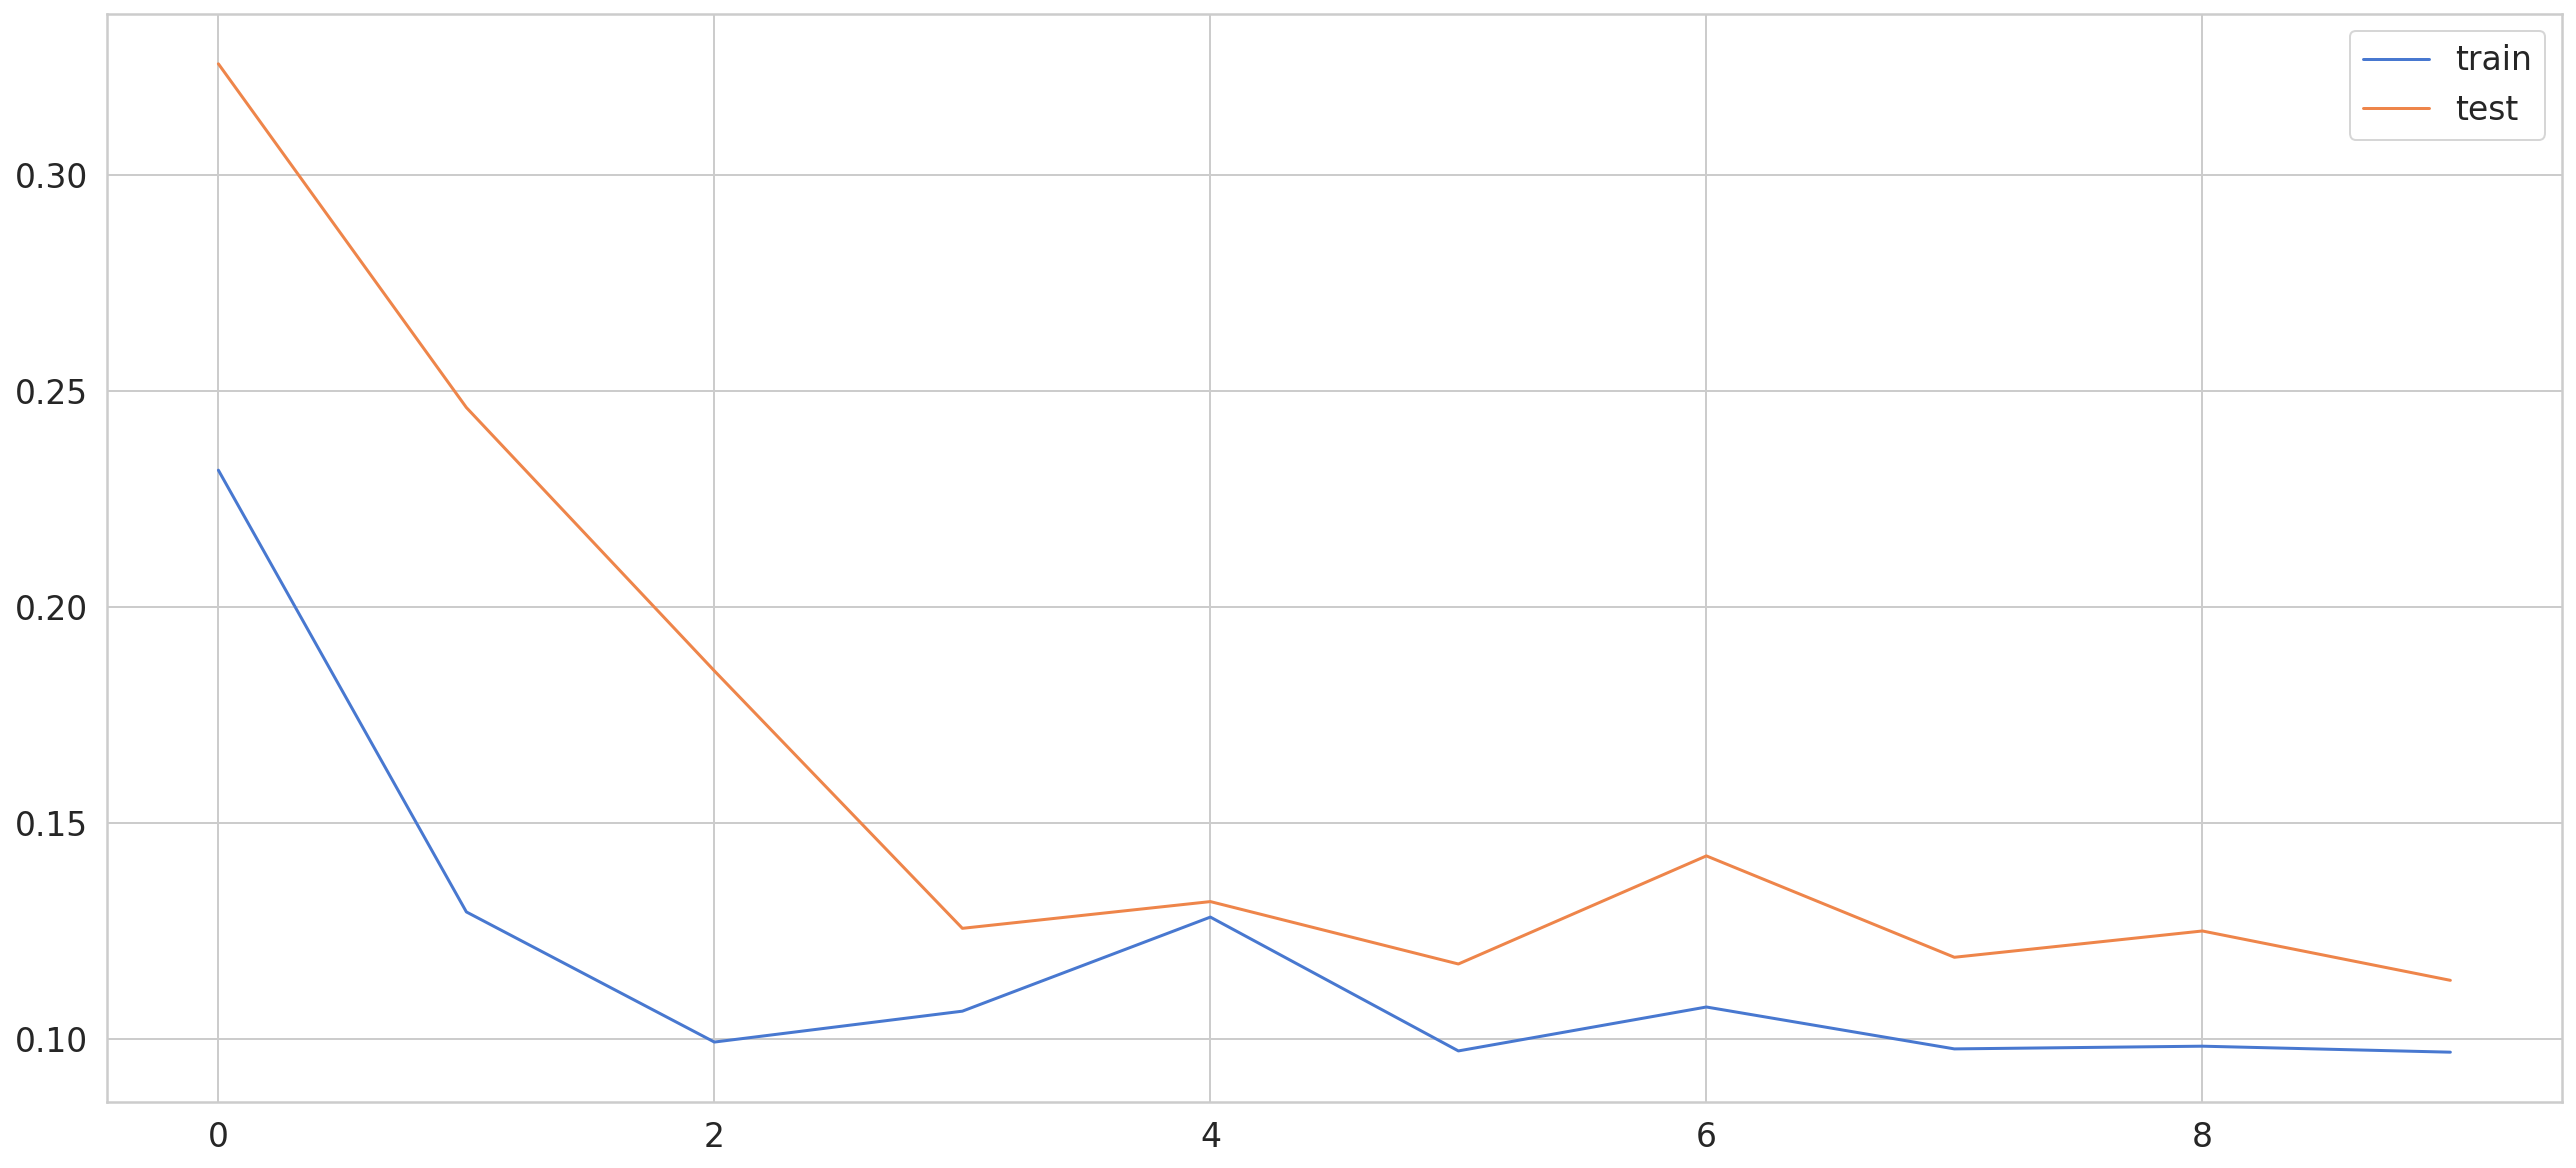

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


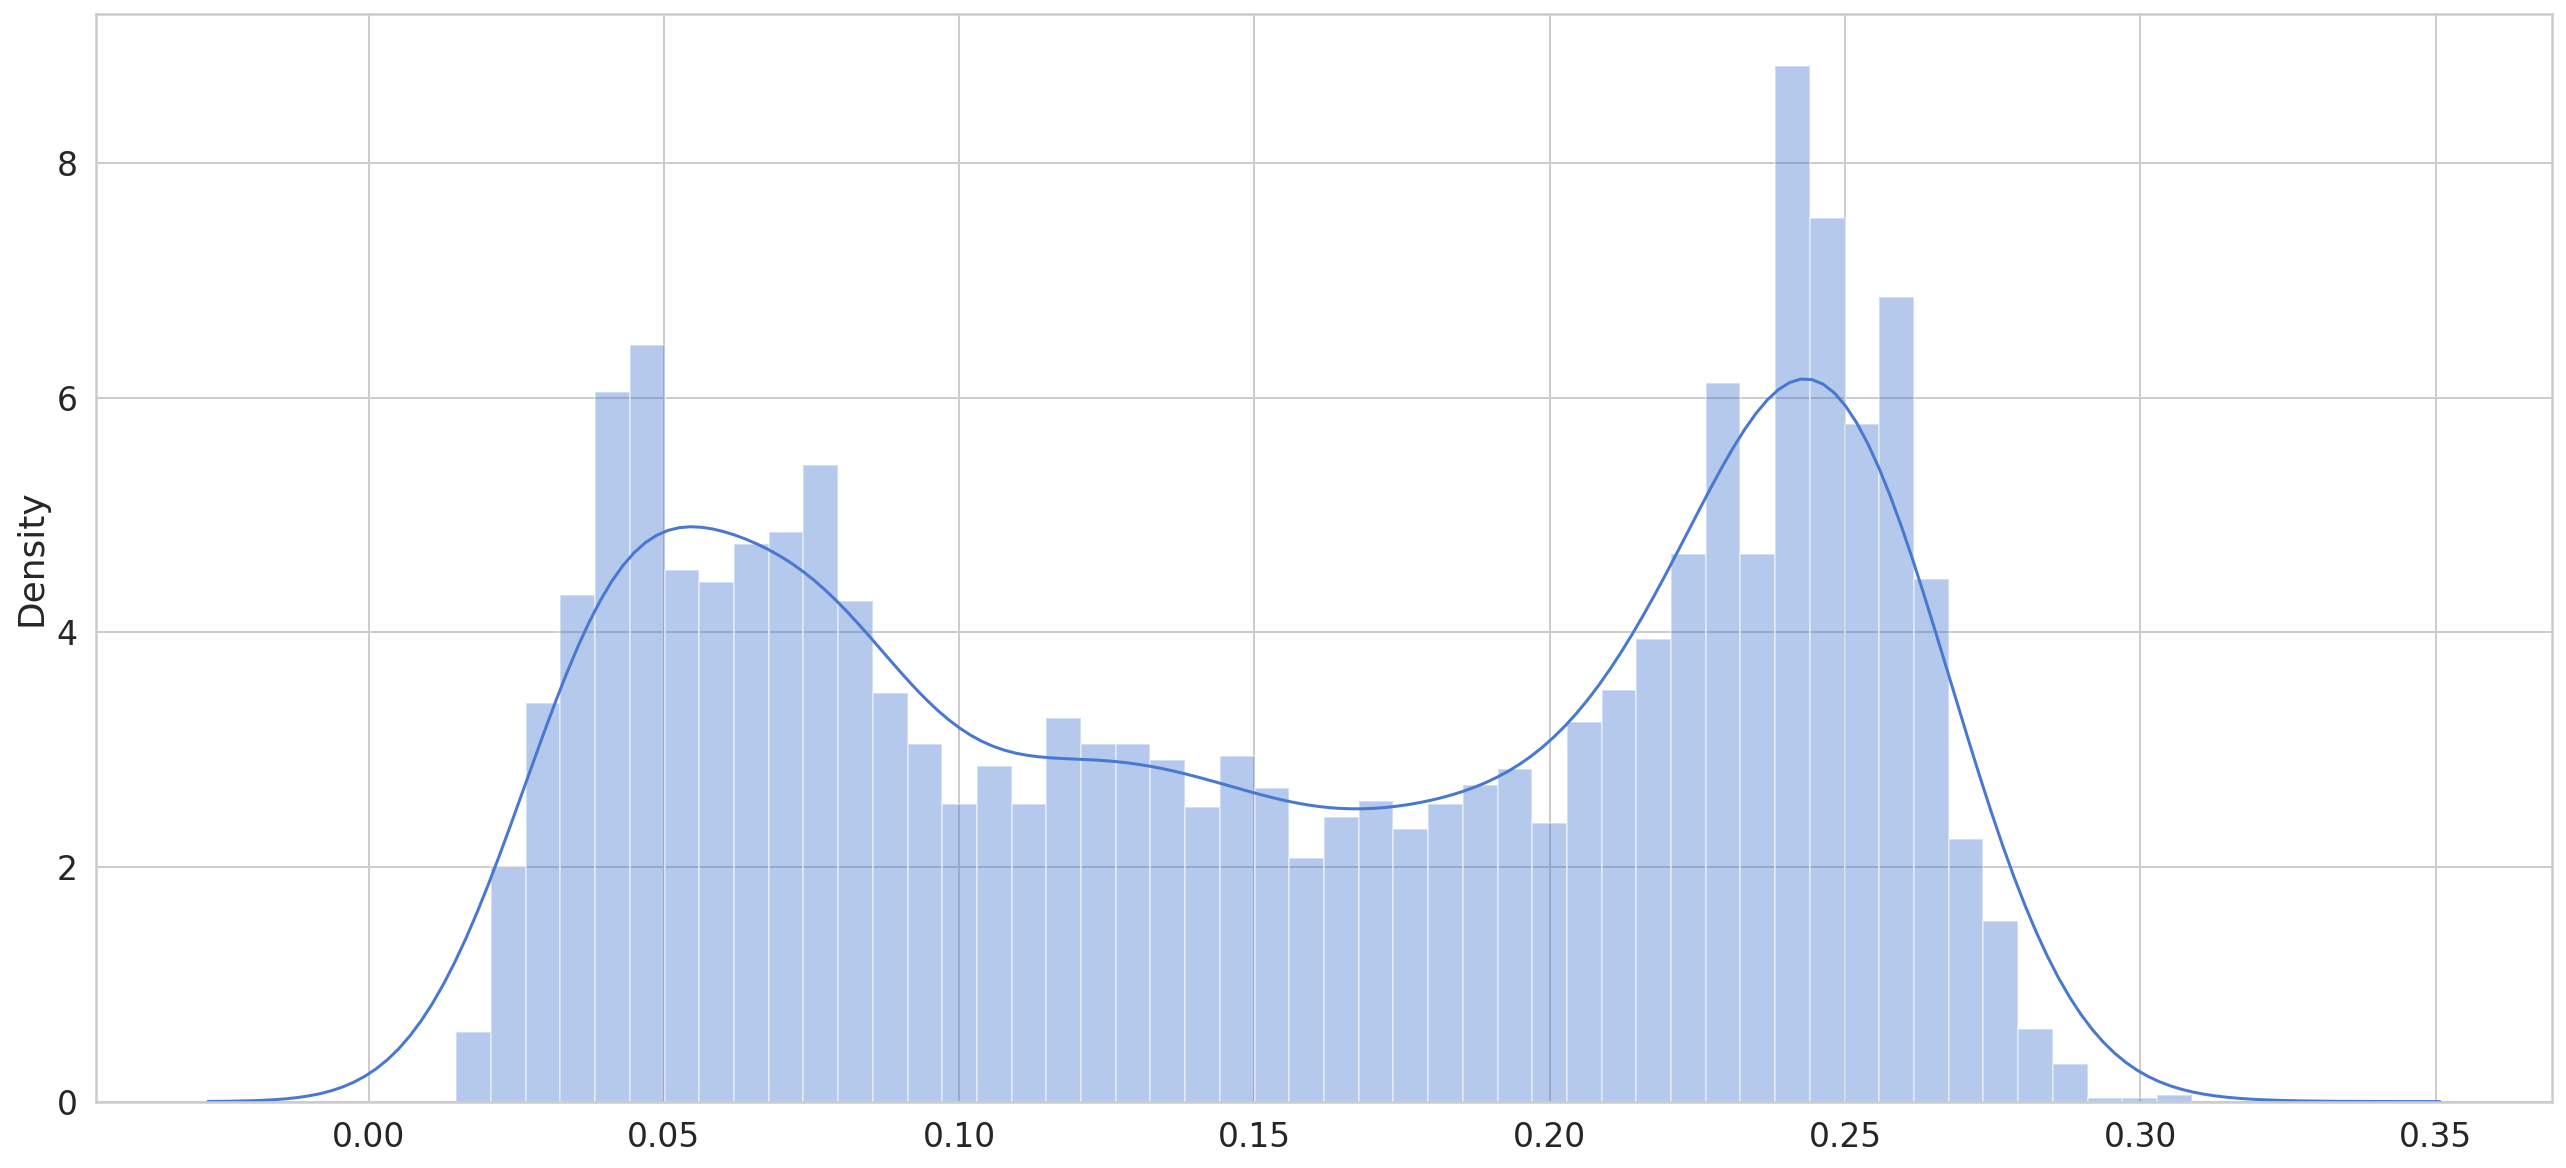

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


## Detect Anomalies in the NIFTY50 Index Data

In [17]:
THRESHOLD = 0.35

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

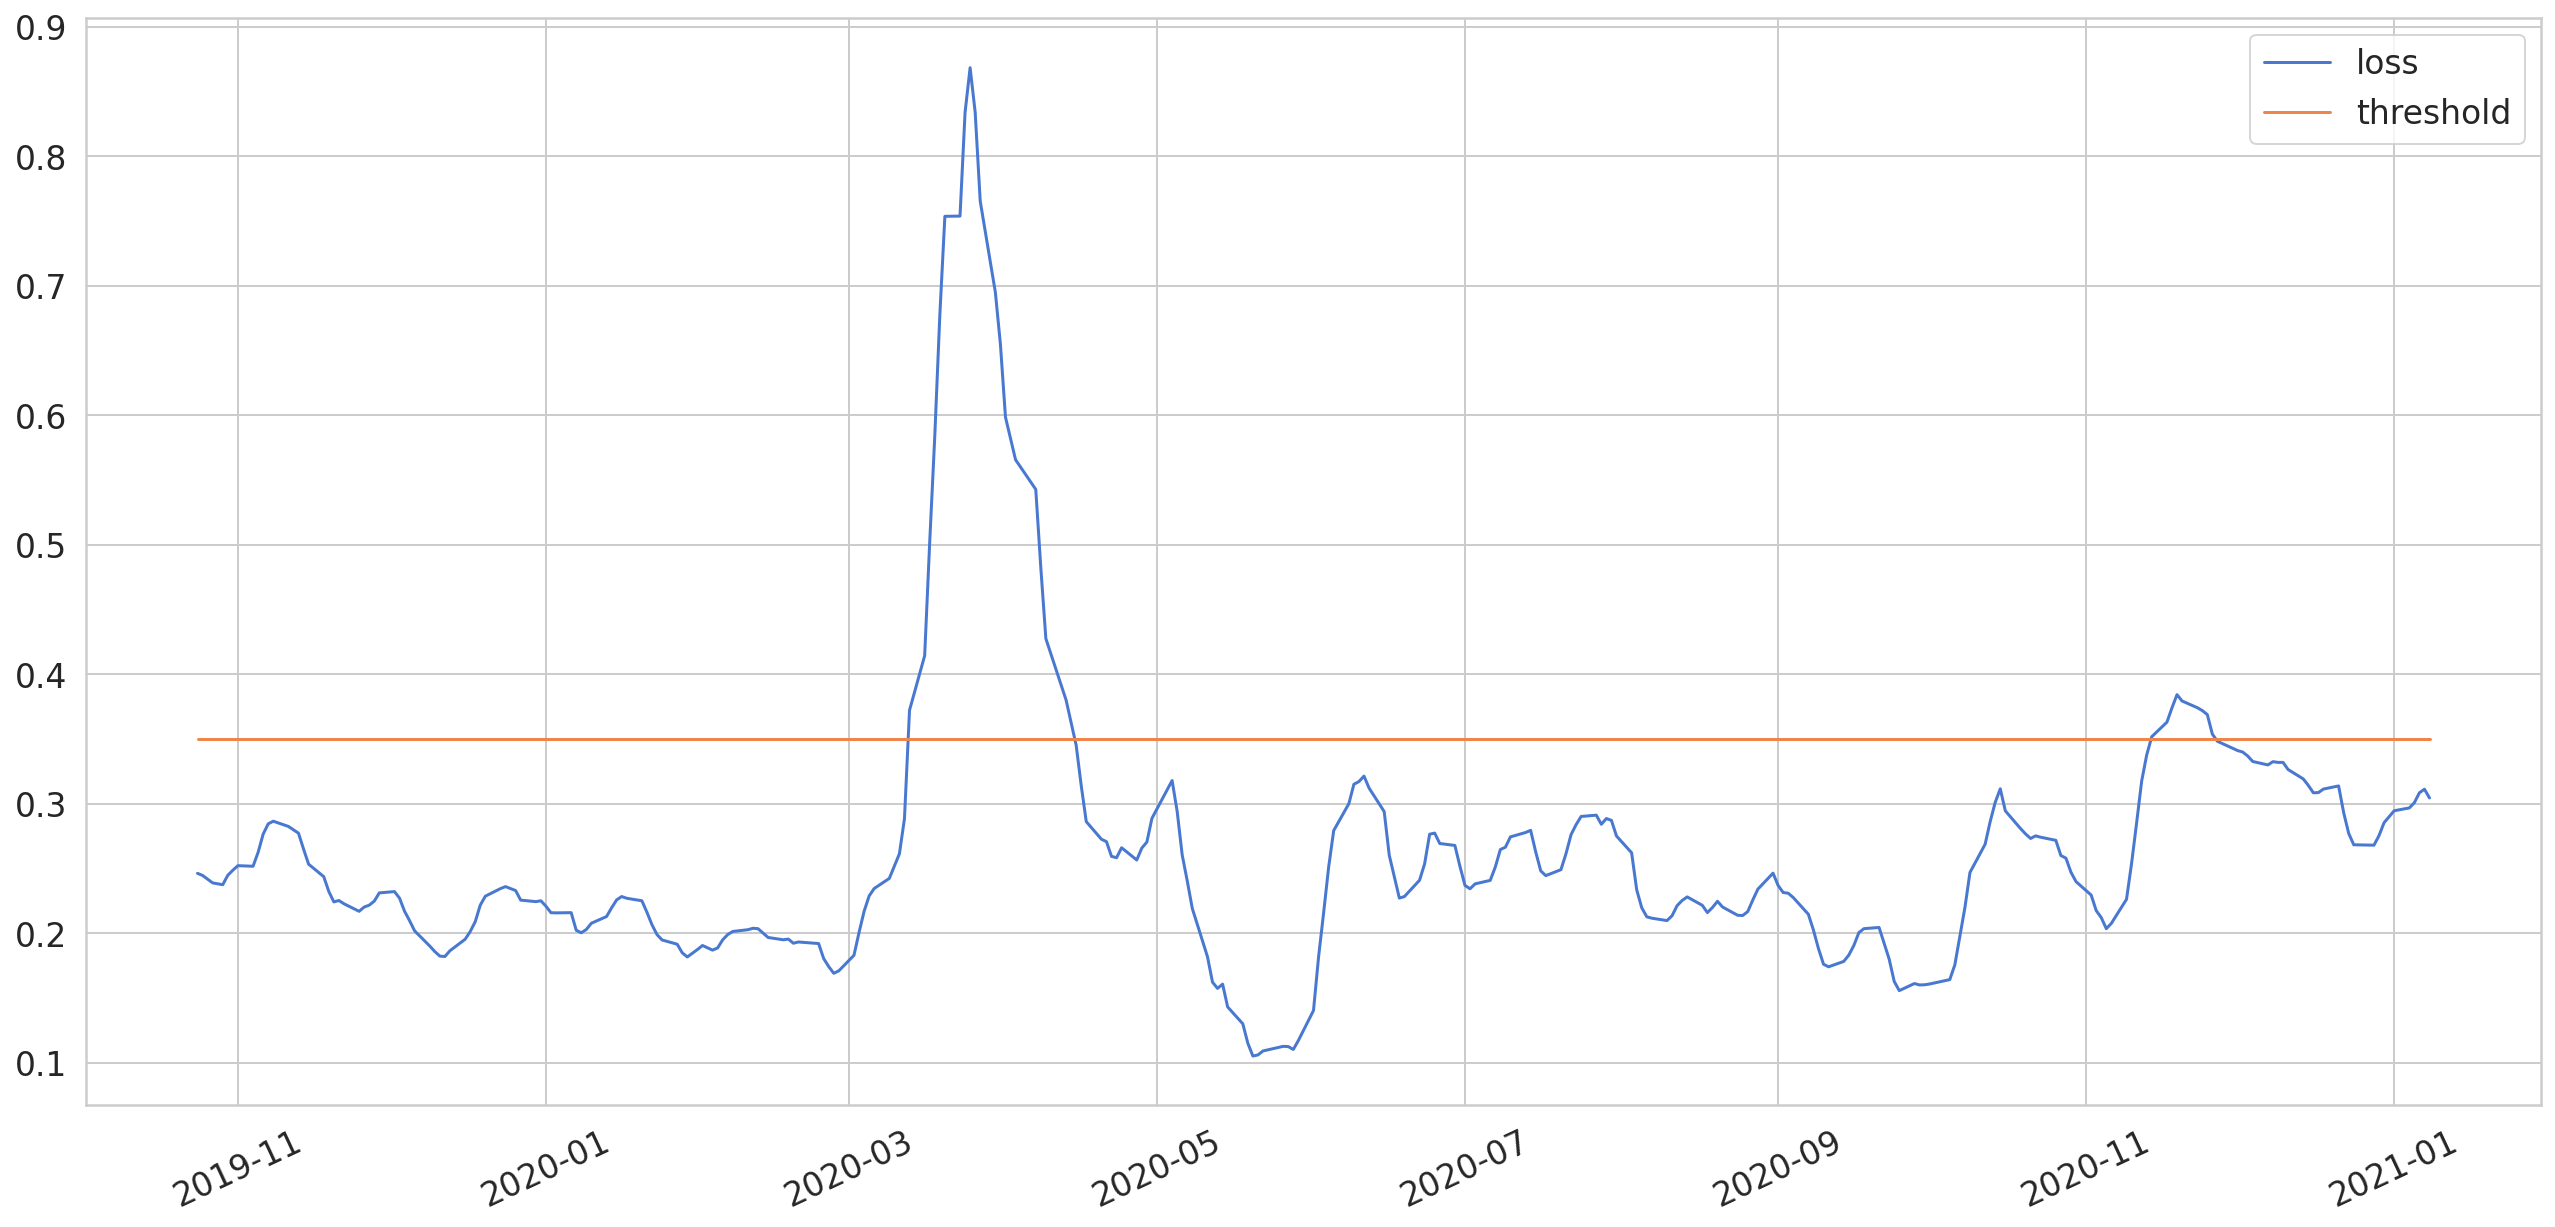

In [18]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [19]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
date,,,,
2020-03-13,0.372384,0.35,True,1.823569
2020-03-16,0.414529,0.35,True,1.587434
2020-03-17,0.502392,0.35,True,1.515655
2020-03-18,0.583852,0.35,True,1.360397
2020-03-19,0.677220,0.35,True,1.296408
2020-03-20,0.753760,0.35,True,1.446603
2020-03-23,0.753930,0.35,True,1.092866
2020-03-24,0.833999,0.35,True,1.152321
2020-03-25,0.868515,0.35,True,1.313359


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


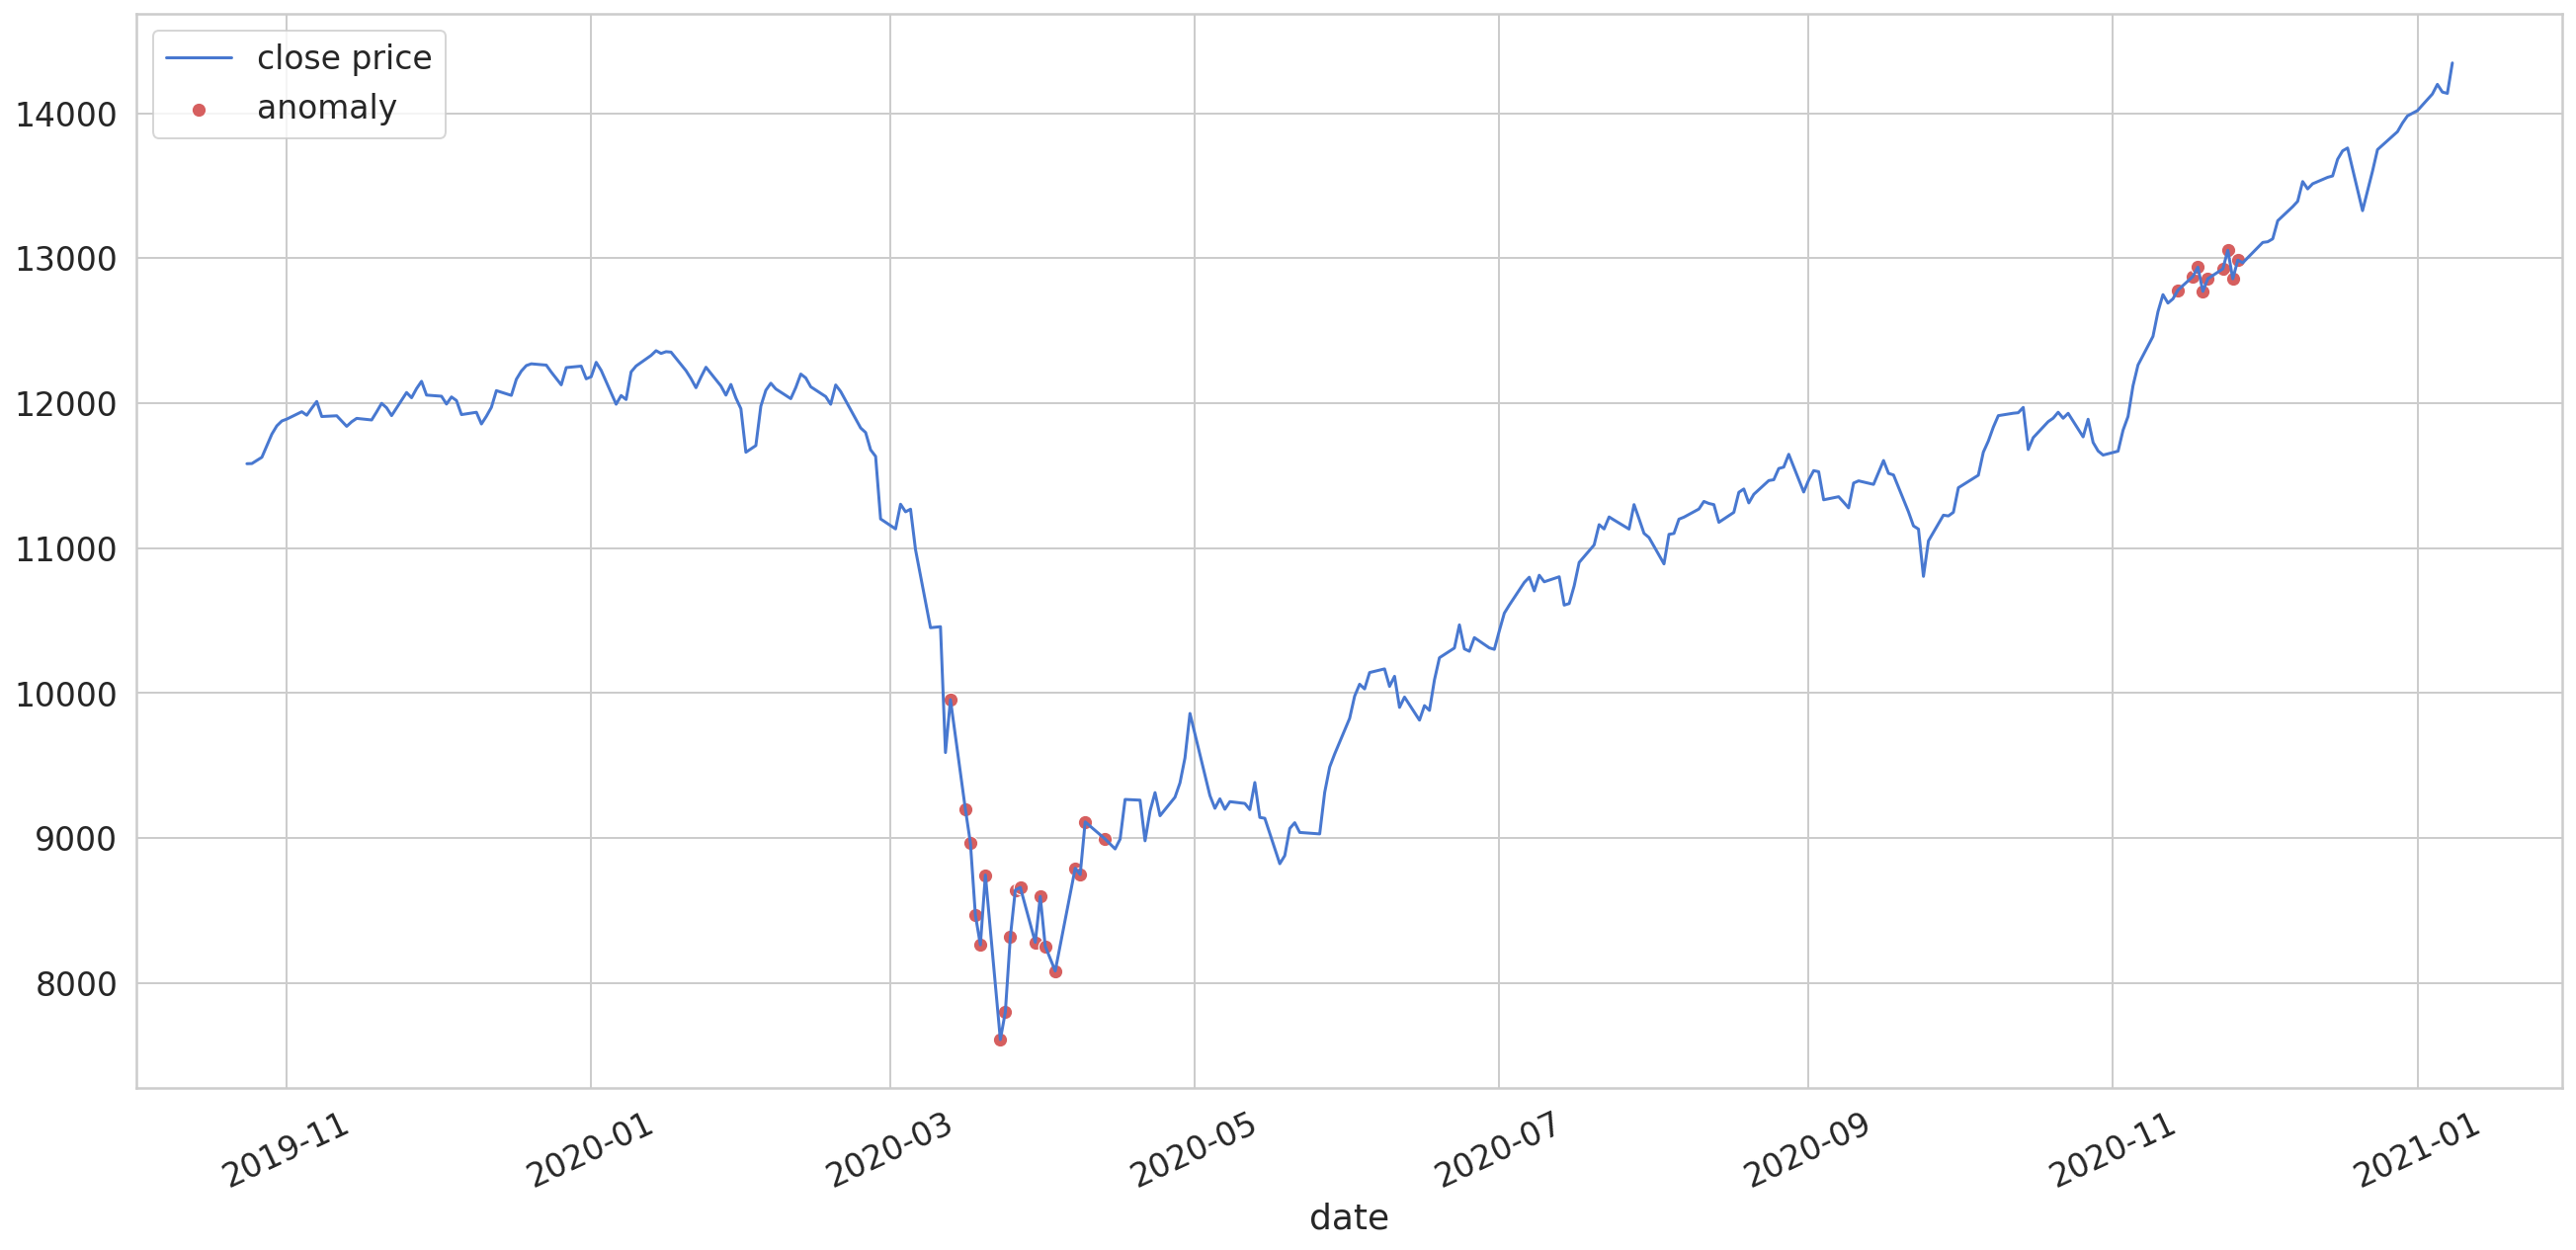

In [20]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();